## GENETIC MEDICINE DEEP LEARNING HACKATHON 2022

### ENFORMER USAGE NOTEBOOK - PARTICIPANT

**Authors**: Saideep Gona, Temidayo Adeluwa

**Acknowledgement**:
- Boxiang Liu
- Festus Nyasimi (for providing us with Predixcan predictions)

**Date**: Saturday April 2, 2022

Copyright 2021 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Introduction

In this notebook, we explore how Enformer can be used to predict the expression of protein-coding genes. We utilized some code from the [original Enformer usage colab notebook](https://colab.research.google.com/github/deepmind/deepmind_research/blob/master/enformer/enformer-usage.ipynb). Here, we showcase how the Enformer model can be used to predict gene expression on a GEUVADIS/1000 genomes dataset, and compare the predictions with true expression.

**"Effective gene expression prediction from sequence by integrating long-range interactions"**

Žiga Avsec, Vikram Agarwal, Daniel Visentin, Joseph R. Ledsam, Agnieszka Grabska-Barwinska, Kyle R. Taylor, Yannis Assael, John Jumper, Pushmeet Kohli, David R. Kelley

### Steps

This notebook demonstrates how to
- Prepare inputs for Enformer to make predictions
- Make predictions with Enformer and produce figures
- Compare predictions with true expression

## Setup

Google Colab gives us some GPU access. This limited GPU is available to anyone with a Google account, who has signed up to use Colaboratory. We will begin by changing the runtime type to GPU. Follow the instruction below by clicking on "Runtime -> Change runtime type -> GPU" in the menu bar below the title of this notebook.

**Start the colab kernel with GPU**: Runtime -> Change runtime type -> GPU


Below, we import tensorflow as tf, and check that the runtime has been changed to GPU.

In [4]:
import tensorflow as tf
# Make sure the GPU is enabled
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'

2023-07-06 02:32:57.968916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


kipoiseq is a package that helps us to extract sequences from fasta files given some intervals. We will install the package.

In [5]:
#%pip install kipoiseq==0.5.2 --quiet > /dev/null
# You can ignore the pyYAML error

Biopython is a python package that helps us do many bioinfomatic analysis in python

In [6]:
#%pip install Biopython

### Setting up our environments

We need to have some packages imported to help us do cool stuff.

In [7]:
import tensorflow_hub as hub # for interacting with saved models and tensorflow hub
import joblib
import gzip # for manipulating compressed files
import kipoiseq # for manipulating fasta files
from kipoiseq import Interval # same as above, really
import pyfaidx # to index our reference genome file
from pyfaidx import Fasta
import pandas as pd # for manipulating dataframeshttps://github.com/microsoft/pyright/blob/main/docs/configuration.md#reportMissingImports
import numpy as np # for numerical computations
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for plotting
import seaborn as sns # for plotting
import pickle # for saving large objects
import os, sys # functions for interacting with the operating system

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



Next,

We want to define some paths to save downloaded files for the duration of this notebook. These will be wiped off by Google as soon as we are done.

In [8]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/grand/TFXcan/imlab/users/tiffanie/enformer/data/genome.fa'

We may inspect the tracks used to train the model. The CAGE prediction corresponding to B lymphoblastoid cell line is index 5110. We use B lymphoblastoid cell line predictions here because that is the cell line used to generate GEUVADIS gene expression data. You can copy the https link, paste in another tab in your browser and look through the large txt file for other tracks.

In [9]:
# Download targets from Basenji2 dataset
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets[df_targets.index==5110]

,index,genome,identifier,file,clip,scale,sum_stat,description
5110,5110,0,CNhs12333,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:B lymphoblastoid cell line: GM12878 ENCOD...


### Download files


We need to download some files. Give it a moment.
We will download the following files:
- The reference genome fasta file (we will also index this file in the process)
- A text file for the transcription start sites for each chromosome
- Per chromosome files that has annotation for the genes
- A compressed file that contains the variant bed files for the genes and their locations.

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

Make a data directory, and download the necessary bed files and chromosome annotation files

**NB:** You may decide to download these files into your "/content/drive/MyDrive/Enformer_Hackathon_2022/" directory. **You don't need to do this**. But if you want permanent access to the files we use in this notebook, you can change the path from "/grand/TFXcan/imlab/users/tiffanie/enformer/data/" to "/content/drive/MyDrive/Enformer_Hackathon_2022/", and modify what you need accordingly.

The next line of code will download the reference genome fasta file and index this file.

In [10]:
# reference genome and indexed
!wget -O - https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)

--2023-07-06 02:33:16--  https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz
Resolving proxy.alcf.anl.gov (proxy.alcf.anl.gov)... 140.221.69.42
Connecting to proxy.alcf.anl.gov (proxy.alcf.anl.gov)|140.221.69.42|:3128... connected.


Proxy request sent, awaiting response... 200 OK
Length: 948731419 (905M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 904.78M  52.1MB/s    in 17s     

2023-07-06 02:33:33 (54.0 MB/s) - written to stdout [948731419/948731419]



Faidx("/grand/TFXcan/imlab/users/tiffanie/enformer/data/genome.fa")

The next lines of code will download the variation bed files, and we have created links to help us download the variation bed files for each chromosome, for each gene.

In [11]:
chrom_bed_downloads = pd.read_csv("https://uchicago.box.com/shared/static/du77wf31li38tciv8imivwu57svae03p.csv")
chrom_bed_downloads.index = chrom_bed_downloads["chroms"]

chrom_bed_downloads.head(5)

,chroms,link
chroms,,
1,1,https://uchicago.box.com/shared/static/9q9n4a0...
2,2,https://uchicago.box.com/shared/static/1tk6a3f...
3,3,https://uchicago.box.com/shared/static/77ldwqq...
4,4,https://uchicago.box.com/shared/static/s0g48al...
5,5,https://uchicago.box.com/shared/static/yafgxb1...


We will define a function to help us download bed variation files for a given gene or list of genes

In [12]:
def download_chrom_beds(chromosome, genes, downloads_table=chrom_bed_downloads):
  '''
  Downloads bed/variation files for a chromosome and list of genes
  '''

  link = downloads_table.loc[str(chromosome), "link"]
  chr_which = 'chr' + chromosome
  for gene in genes:
    if os.path.exists('/grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr' + chromosome + '/chr' + chromosome + '_' + gene + '.bed'): # if the file is in the folder, no need to download again
      continue
    !curl -L {link} --output /grand/TFXcan/imlab/users/tiffanie/enformer/data/chr_{chromosome}_bed.tar.gz && cd /grand/TFXcan/imlab/users/tiffanie/enformer/data/ && tar -zxf /grand/TFXcan/imlab/users/tiffanie/enformer/data/chr_{chromosome}_bed.tar.gz ./individual_beds/{chr_which}/{chr_which}_{gene}.bed

    # remove the download tar.gz file
    !rm /grand/TFXcan/imlab/users/tiffanie/enformer/data/chr_{chromosome}_bed.tar.gz

We don't need this function yet. But we can test out how it works.

Assuming we want to download the variation files for 'ERAP1', which is located on chromosome 5...

This will download the bed file into /grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr5/

In [13]:
download_chrom_beds(chromosome = '5', genes=['ERAP1', 'ERAP2'])

And when you need the file, you can read it in like...

In [14]:
erap1_variations = pd.read_table('/grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr5/chr5_ERAP1.bed', sep='\t')
erap1_variations.head(5)

,#CHROM,POS,REF,ALT,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,5,95923584,T,C,1|0,0|1,0|0,0|0,0|1,0|1,...,0|0,1|0,1|0,0|0,0|1,0|0,0|0,0|1,0|0,1|0
1,5,95923823,A,G,1|0,0|1,0|0,0|0,0|1,0|1,...,0|0,1|0,1|0,0|0,0|1,0|0,0|0,0|1,0|0,1|0
2,5,95923836,G,A,1|0,0|1,0|0,0|0,0|1,0|1,...,0|0,1|0,1|0,0|0,0|1,0|0,0|0,0|1,0|0,1|0
3,5,95924552,T,C,1|0,0|1,0|0,0|0,0|1,0|1,...,0|0,1|0,1|0,0|0,0|1,0|0,0|0,0|1,0|0,1|0
4,5,95925045,T,A,1|0,0|1,0|0,0|0,0|1,0|1,...,0|0,1|0,1|0,0|0,0|1,0|0,0|0,0|1,0|0,1|0


You can pass in a list of genes as long as they are all located on that chromosome.

In the next block of code, we download the TSS for each chromosome and the genes in that chromosome, as wells as the per chromosome gene annotations. We need this information to estimate predictions.


In [15]:
!curl -L https://uchicago.box.com/shared/static/perc3uabzzd267cbp8zc0inwgrmur7pu.gz --output /grand/TFXcan/imlab/users/tiffanie/enformer/data/chr_tss.tar.xz && cd /grand/TFXcan/imlab/users/tiffanie/enformer/data/ && tar -zxf /grand/TFXcan/imlab/users/tiffanie/enformer/data/chr_tss.tar.xz

!mkdir -p /grand/TFXcan/imlab/users/tiffanie/enformer/data/gene_chroms #creates a folder to hold our files
!curl -L https://uchicago.box.com/shared/static/e2kiwrjlgqqio0pc37a2iz7l5bqbv57u.gz --output /grand/TFXcan/imlab/users/tiffanie/enformer/data/gene_chroms/gene_chroms.tar.gz && cd /grand/TFXcan/imlab/users/tiffanie/enformer/data/gene_chroms/ && tar -zxf /grand/TFXcan/imlab/users/tiffanie/enformer/data/gene_chroms/gene_chroms.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      6      0 --:--:--  0:00:01 --:--:--  7000
100 1783k  100 1783k    0     0   978k      0  0:00:01  0:00:01 --:--:-- 4078k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     6    0     6    0     0      6      0 --:--:-- --:--:-- --:--:--    11
100  728k  100  728k    0     0   575k      0  0:00:01  0:00:01 --:--:--  575k


### How do we want to go about using Enformer given all these files we just downloaded?

As we know, enformer's input is a single strand genome sequence. Yet, we are interested in predicting on population level data which includes individual-specific variation. To get around this limitation, we will treat each individual as the sum of their haplotypes. Using the phased variant data around each gene (stored in the variant bed files) to modify the reference sequence, we can create two distinct haplotype sequences for each individual. The sum of both of Enformer's haplotype predictions serves as an individual-specific, additive estimate which we can correlate with true predictions. Together, the files we downloaded give us all the information we need to build these haplotype sequences.

Althought enformer predicts a wide array of functional output, we will focus here on gene expression in lymphoblastoid cells allowing for correlation against ground truth Geuvadis gene expression data.

There are many functions that we have defined in the next code block. You can explore them later, but for now, simply run the block by clicking on the play button.

### Code

Next, we have some functions that will help us along the way. Classes and methods defined in this code block can be found in the [original Enformer usage colab notebook](https://colab.research.google.com/github/deepmind/deepmind_research/blob/master/enformer/enformer-usage.ipynb).

In [16]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.


# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)



# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

Here, we define some utility functions for ourselves, to help us make predictions and analyse our predictions.

In [17]:
import Bio

from Bio.Seq import Seq
def create_rev_complement(dna_string):
    return(str(Seq(dna_string).reverse_complement()))

In [18]:
def prepare_for_quantify_prediction_per_TSS(predictions, gene, tss_df):

  '''

  Parameters:
          predicitions (A numpy array): All predictions from the track
          gene (a gene name, character): a gene
          tss_df: a list of dataframe of genes and their transcription start sites
  Returns:
          A dictionary of cage experiment predictions and a list of transcription start sites

  '''

  output = dict()
  for tdf in tss_df:
    if gene not in tdf.genes.values:
      continue
    gene_tss_list = tdf[tdf.genes == gene].txStart_Sites.apply(str).values
    gene_tss_list = [t.split(', ') for t in gene_tss_list]
    gene_tss_list = [int(item) for nestedlist in gene_tss_list for item in nestedlist]
    gene_tss_list = list(set(gene_tss_list))
  output['cage_predictions'] = predictions[:, 5110] # a numpy array
  output['gene_TSS'] = gene_tss_list # a list


  return(output) # a dictionary

def quantify_prediction_per_TSS(low_range, TSS, cage_predictions):

  '''
  Parameters:
          low_range (int): The lower interval
          TSS (list of integers): A list of TSS for a gene
          cage_predictions: A 1D numpy array or a vector of predictions from enformer corresponding to track 5110 or CAGE predictions
  Returns:
          A dictionary of gene expression predictions for each TSS for a gene
    '''
  tss_predictions = dict()
  for tss in TSS:
    bin_start = low_range + ((768 + 320) * 128)
    count = -1
    while bin_start < tss:
      bin_start = bin_start + 128
      count += 1
    if count >= len(cage_predictions)-1:
      continue
    cage_preds = cage_predictions[count - 1] + cage_predictions[count] + cage_predictions[count + 1]
    tss_predictions[tss] = cage_preds

  return(tss_predictions)

def collect_intervals(chromosomes = ["22"], gene_list=None):

  '''
    Parameters :
      chromosomes : a list of chromosome numbers; each element should be a string format
      gene_list : a list of genes; the genes should be located on those chromosomes

    Returns :
      A dictionary of genes (from gene_list) and their intervals within their respective chromosomes
  '''

  gene_intervals = {} # Collect intervals for our genes of interest

  for chrom in chromosomes:
    with open("/grand/TFXcan/imlab/users/tiffanie/enformer/data/gene_chroms/gene_"+ chrom + ".txt", "r") as chrom_genes:
      for line in chrom_genes:
        split_line = line.strip().split("\t")
        gene_intervals[split_line[2]] = [
                                          split_line[0],
                                          int(split_line[3]),
                                          int(split_line[4])
                                        ]

  if isinstance(gene_list, list): # if the user has supplied a list of genes they are interested in
    use_genes = dict((k, gene_intervals[k]) for k in gene_list if k in gene_intervals)
    return(use_genes)
  elif isinstance(gene_list, type(None)):
    return(gene_intervals)


def run_predictions(gene_intervals, tss_dataframe, individuals_list=None):
  '''
  Parameters :
    gene_intervals : the results from calling `collect_intervals`
    tss_dataframe : a list of the TSSs dataframes i.e. the TSS for the genes in the chromosomes
    individuals_list : a list of individuals on which we want to make predictions; defaults to None

  Returns :
    A list of predictions; the first element is the predictions around the TSS for each gene. The second is the prediction across CAGE tracks
  '''

  gene_output = dict()
  gene_predictions = dict()

  for gene in gene_intervals.keys():
    gene_interval = gene_intervals[gene]
    target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2]) # creates an interval to select the right sequences
    target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))  # extracts the fasta sequences, and resizes such that it is compatible with the sequence_length
    window_coords = target_interval.resize(SEQUENCE_LENGTH) # we also need information about the start and end locations after resizing
    try:
      cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene
    except:
      continue
    individual_results = dict()
    individual_prediction = dict()

    if isinstance(individuals_list, list) or isinstance(individuals_list, type(np.empty([1, 1]))):
      use_individuals = individuals_list
    elif isinstance(individuals_list, type(None)):
      use_individuals = cur_gene_vars.columns[4:]

    for individual in use_individuals:
      print('Currently on gene {}, and predicting on individual {}...'.format(gene, individual))
      # two haplotypes per individual
      haplo_1 = list(target_fa[:])
      haplo_2 = list(target_fa[:])

      ref_mismatch_count = 0
      for i,row in cur_gene_vars.iterrows():

        geno = row[individual].split("|")
        if (row["POS"]-window_coords.start-1) >= len(haplo_2):
          continue
        if (row["POS"]-window_coords.start-1) < 0:
          continue
        if geno[0] == "1":
          haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
        if geno[1] == "1":
          haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]

      # predict on the individual's two haplotypes
      prediction_1 = model.predict_on_batch(one_hot_encode("".join(haplo_1))[np.newaxis])['human'][0]
      prediction_2 = model.predict_on_batch(one_hot_encode("".join(haplo_2))[np.newaxis])['human'][0]

      temp_predictions = [prediction_1[:, 5110], prediction_2[:, 5110]] # CAGE predictions we are interested in
      individual_prediction[individual] = temp_predictions

      # Calculate TSS CAGE expression which correspond to column 5110 of the predictions above
      temp_list = list()

      pred_prepared_1 = prepare_for_quantify_prediction_per_TSS(predictions=prediction_1, gene=gene, tss_df=tss_dataframe)
      tss_predictions_1 = quantify_prediction_per_TSS(low_range = window_coords.start, TSS=pred_prepared_1['gene_TSS'], cage_predictions=pred_prepared_1['cage_predictions'])

      pred_prepared_2 = prepare_for_quantify_prediction_per_TSS(predictions=prediction_2, gene=gene, tss_df=tss_dataframe)
      tss_predictions_2 = quantify_prediction_per_TSS(low_range = window_coords.start, TSS=pred_prepared_2['gene_TSS'], cage_predictions=pred_prepared_2['cage_predictions'])

      temp_list.append(tss_predictions_1)
      temp_list.append(tss_predictions_2) # results here are a dictionary for each TSS for each haplotype

      individual_results[individual] = temp_list # save for the individual

    gene_output[gene] = individual_results
    gene_predictions[gene] = individual_prediction

  return([gene_output, gene_predictions])


def collect_target_intervals(gene_intervals):

  '''
  Returns a dictionary of Interval objects (from kipoiseq) for each gene corresponding to the locations of the gene
  '''

  target_intervals_dict = dict()

  for gene in gene_intervals.keys():
    gene_interval = gene_intervals[gene]
    target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2])
    target_intervals_dict[gene] = target_interval

  return(target_intervals_dict)

def prepare_for_plot_tracks(gene, individual, all_predictions, chromosome=['22']):

  '''
  This returns a dictionary of gene tracks and gene intervals, prepared for the function plot_tracks.

  Parameters:
    - gene
    - individual
    - all_predictions
  '''

  haplo_predictions = all_predictions[gene][individual]
  gene_tracks = {gene + ' | ' + individual + ' | haplotype 1': np.log10(1 + haplo_predictions[0]),
                gene + ' | ' + individual + ' | haplotype 2': np.log10(1 + haplo_predictions[1])}

  gene_intervals = collect_intervals(chromosomes=chromosome, gene_list=[gene])
  gene_intervals = collect_target_intervals(gene_intervals)

  output = dict()
  output['gene_tracks'] = gene_tracks
  output['gene_intervals'] = gene_intervals[gene]

  return(output)

def check_individuals(path_to_bed_file, list_of_individuals):

  '''
  Checks if an individual is missing in bed variation files.
  These individuals should be removed prior to training
  '''

  myfile = open(path_to_bed_file, 'r')
  myline = myfile.readline()
  bed_names = myline.split('\t')[4:]
  myfile.close()

  if set(list_of_individuals).issubset(set(bed_names)) == False:
    missing = list(set(list_of_individuals).difference(bed_names))
    print('This (or these) individual(s) is/are not present: {}'.format(missing))
  else:
    missing = []
    print('All individuals are present in the bed file.')

  return(missing)

In [19]:
def plot_predixcan_vs_geuvadis(interested_gene, interested_individuals, geuvadis_expression, predixcan_expression):

  '''
  Show a plot and return correlation coefficient
  '''
  # from predixcan expression
  df_predixcan = predixcan_expression[predixcan_expression.gene_name == interested_gene].loc[:,interested_individuals]
  # from enformer
  df_geuvadis = geuvadis_expression[geuvadis_expression.gene_name == interested_gene].loc[:,interested_individuals]

  # concatenate both
  df_all = pd.concat([df_predixcan, df_geuvadis], axis=0)
  df_all.index = ['Predixcan', 'GEUVADIS']

  # plotting
  sns.regplot(x=df_all.iloc[0,:], y=df_all.iloc[1,:], color='red').set(title='Predixcan vs. GEUVADIS predictions on {} individuals for gene {}'.format(len(df_all.columns), interested_gene))

  # correlation coefficient
  corr_coef = np.corrcoef(x=df_all.iloc[0,:], y=df_all.iloc[1,:])[0][1]

  return([df_all, corr_coef])

def plot_enformer_vs_predixcan(prediction_results, interested_gene, interested_individuals, predixcan_expression, how='sum'):

  '''
  Show a plot and return correlation coefficient
  '''

  enformer_predictions = dict()

  for gene, individuals in prediction_results[0].items():
    temp_individual = dict()
    for individual, haplo_predictions in individuals.items():
      temp = list()
      for i in range(0, len(haplo_predictions[0])):
        temp.append(list(haplo_predictions[0].values())[i] + list(haplo_predictions[1].values())[i])
      if how == 'sum':
        temp_individual[individual] = np.sum(temp)
      elif how == 'max':
        temp_individual[individual] = np.max(temp)
    enformer_predictions[gene] = temp_individual

  # from predixcan expression
  df_predixcan = predixcan_expression[predixcan_expression.gene_name == interested_gene].loc[:,interested_individuals]
  # from enformer
  df_enformer = pd.DataFrame(enformer_predictions[interested_gene], index=[0]).loc[:, df_predixcan.columns]

  # concatenate both
  df_all = pd.concat([df_enformer, df_predixcan], axis=0)
  df_all.index = ['Enformer', 'Predixcan']

  # plotting
  sns.regplot(x=df_all.iloc[0,:], y=df_all.iloc[1,:], color='red').set(title='Predixcan vs. Enformer predictions on {} individuals for gene {}'.format(len(df_all.columns), interested_gene))

  # correlation coefficient
  corr_coef_predix = np.corrcoef(x=df_all.iloc[0,:], y=df_all.iloc[1,:])[0][1]

  return([df_all, corr_coef_predix])


def plot_enformer_vs_geuvadis(prediction_results, interested_gene, interested_individuals, geuvadis_expression, how='sum'):

  '''
  Show a plot and return correlation coefficient
  '''

  enformer_predictions = dict()

  for gene, individuals in prediction_results[0].items():
    temp_individual = dict()
    for individual, haplo_predictions in individuals.items():
      temp = list()
      for i in range(0, len(haplo_predictions[0])):
        temp.append(list(haplo_predictions[0].values())[i] + list(haplo_predictions[1].values())[i])
      if how == 'sum':
        temp_individual[individual] = np.sum(temp)
      elif how == 'max':
        temp_individual[individual] = np.max(temp)
    enformer_predictions[gene] = temp_individual

  # from geuvadis expression
  df_geuvadis = geuvadis_expression[geuvadis_expression.gene_name == interested_gene].loc[:,interested_individuals]
  #df_enformer = np.transpose(pd.DataFrame(enformer_predictions)).loc[:, df_geuvadis.columns]
  df_enformer = pd.DataFrame(enformer_predictions[interested_gene], index=[0]).loc[:, df_geuvadis.columns]

  # concatenate both
  df_all = pd.concat([df_enformer, df_geuvadis], axis=0)
  df_all.index = ['Enformer', 'GEUVADIS']

  # plotting
  sns.regplot(x=df_all.iloc[0,:], y=df_all.iloc[1,:], color='blue').set(title='Enformer vs. Geuvadis predictions on {} individuals for gene {}'.format(len(df_all.columns), interested_gene))

  # correlation coefficient
  corr_coef_geu = np.corrcoef(x=df_all.iloc[0,:], y=df_all.iloc[1,:])[0][1]

  return([df_all, corr_coef_geu])


## Make predictions on the GEUVADIS dataset.

Here, we will begin to make predictions. Excited?!

We still need the model itself. The model has been graciously hosted on [Tensorflow Hub](https://tfhub.dev/deepmind/enformer/1), which hosts many other models too. You can click on the link and explore. When you click the link, you can see that the model is about 892 Mb large. Quite big.
We will use the url to the model to download and use it here.

Earlier, we defined an Enformer class (see the codes section). We will load the model into this class. The model has been trained and the weights are freely available. All we need to do is to load this model and use it. Neat.

We also defined a class FastaStringExtractor, that can help us extract raw sequences from fasta files given the intervals we want. We will make use of this class too.

In [20]:
model = Enformer(model_path) # here we load the model architecture.
fasta_extractor = FastaStringExtractor(fasta_file) # we define a class called fasta_extractor to help us extra raw sequence data

### **EXERCISE 1:**

For evaluation, we need to **sum the predictions around each unique TSS for a given gene**. We will be using this a lot so it is important that we define what it means. Essentially, for a gene with one TSS, we take the sum of predicitions of the 128 bp output bin containing the TSS and its two immediate neighboring bins. We do this for each haplotype and each TSS to give TSS-level predictions.

To get individual-level estimates for a whole gene, we sum each haplotype TSS estimate to summarize TSS-level predictions per individual, and then take either the sum or max of TSS-level predictions to summarize at the gene level.


There are many genes and many individuals in our datasets. To make illustration simpler, we will use four genes, *ERAP1*, *ERAP2*, *NUDT2*, and *PEX6*, located on chromosome 5, 5, 9, and 6 respectively. We will use predictions for 10 randomly selected individuals located in the bed files.

In [21]:
download_chrom_beds(chromosome = "5", genes = ['ERAP1', 'ERAP2'])
download_chrom_beds(chromosome = "9", genes = ['NUDT2'])
download_chrom_beds(chromosome = "6", genes = ['PEX6'])



Here, we read into a dataframe the TSS (transcription start sites) per gene for the chromosomes we are interested in. The dataframe has three columns. The first contains the genes, and the second contains the TSS(s) for that gene, and the third contains the strand information. We are interested in genes located on chromosomes 5, 6 and 9.

In [22]:
chr5_tss = pd.read_table('/grand/TFXcan/imlab/users/tiffanie/enformer/data/tss_by_chr/chr5_tss_by_gene.txt', sep='\t')
chr6_tss = pd.read_table('/grand/TFXcan/imlab/users/tiffanie/enformer/data/tss_by_chr/chr6_tss_by_gene.txt', sep='\t')
chr9_tss = pd.read_table('/grand/TFXcan/imlab/users/tiffanie/enformer/data/tss_by_chr/chr9_tss_by_gene.txt', sep='\t')

chr9_tss.head(10)

,genes,txStart_Sites,strand
0,DDX11L5,"11987, 12134",+
1,XXyac-YRM2039.2,"29739, 25007, 19145, 29259",-
2,MIR1302-11,27657,+
3,MIR1302-9,30144,+
4,FAM138C,"35841, 35856",-
5,RP11-143M1.7,52680,-
6,RP11-143M1.2,"72701, 72706, 72716",+
7,RP11-143M1.3,"102850, 102941",-
8,RP11-143M1.4,113754,-
9,FOXD4,118417,-


#### Preparing inputs for Enformer

Now that we have downloaded the genetic information that we need, we want to prepare the inputs for Enformer.

We need the following
- The genes we want to predict for
- The genomic interval for these genes
- Information about the transcription start sites for these genes
- The individuals we want to predict for

We have a utility function that helps to define the intervals of a gene, and resize this interval to make it acceptable for Enformer. Enformer needs a specific, defined sequence length. We use the **collect_intervals** function. The result is a dictionary that contains chromosome and interval information for each gene.

For example, let's explore ERAP1...

In [23]:
ERAP1_intervals = collect_intervals(chromosomes=['5'], gene_list=['ERAP1'])
ERAP1_target_intervals = collect_target_intervals(ERAP1_intervals)
ERAP1_intervals, ERAP1_target_intervals

({'ERAP1': ['5', 96096521, 96143803]},
 {'ERAP1': Interval(chrom='chr5', start=96096521, end=96143803, name='', strand='.', ...)})

**ERAP1_target_intervals** is an Interval object created using the kipoiseq package we installed earlier. It is used during predictions, and we don't need to know the methods of this object for the purpose of the next questions.

However, we have similar information in **ERAP1_intervals**, which is a python dictionary of lists. For the questions below, we will use the **ERAP1_intervals** object.

#### ***Question 1a***

What is the size of this interval? *Hint*: Look at the **ERAP1_intervals**, and remember that Python is 0-based indexed. You need to access the **key** of this dictionary, which is the gene name, and for the value, which is a list, you can access the first element using 0, the second element using 1, and so on.

In [24]:
ERAP1_intervals["ERAP1"][2]-ERAP1_intervals["ERAP1"][1]

47282

#### ***Note***

You can roughly confirm this interval by going to the UCSC genome browser or Ensemble genome browser. We have provided a link for UCSC genome browser's interval length [for ERAP1 here](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg19&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr5%3A96096517%2D96143648&hgsid=1316458921_99pz1X7GNzmiEg0WV1q2UmDp9nSB). Click on this link, the answer is right at the top of the browser.

Enformer takes in a defined sequence length. When we provide a gene and collect its intervals, we need to resize this interval to be acceptable for Enformer. Here, we will use the Intervals object define earlier, **ERAP1_target_intervals**.

In [25]:
ERAP1_target_interval_resized = ERAP1_target_intervals['ERAP1'].resize(SEQUENCE_LENGTH)
ERAP1_target_interval_resized

Interval(chrom='chr5', start=95923554, end=96316770, name='', strand='.', ...)

#### ***Question 1b***

What is the length of this interval? Simply run the next line of code.

In [26]:
ERAP1_target_interval_resized.end - ERAP1_target_interval_resized.start

393216

Essentially, we resized the length of the gene and pad it with the native sequences to the left and to the right, such that the length of the input sequence is 393216, and we can imagine our gene right at the center of this wider interval. This is the same interval length used to train ENCODE data to build Enformer. Since this value is pre-define, we really cannot change it. This is information that Enformer uses to make very good predictions. Below, we confirm that this is true.

In [27]:
(ERAP1_target_interval_resized.end - ERAP1_target_interval_resized.start) == SEQUENCE_LENGTH

True

#### Making predictions with Enformer

We will select 10 individuals (we have provided 10 randomly sample individuals for ease), and use four genes, *ERAP1*, *ERAP2*, *NUDT2*, and *PEX6*, located on chromosome 5, 5, 9, and 6 respectively

We will collect the intervals that correspond to these genes, collect the sequences for that interval from the reference fasta file, loop through each individual's variations in the bed files we provided, switch around the variations for each haplotype and predict expression.

Eventually, for each individual, we should have predictions corresponding to each haplotype. We expect that since the haplotypes are different, the predictions should vary too.

Additionally, we need the TSS for these genes. Remember that we read in the dataframe earlier.

In [28]:
exercise_1_genes = ['ERAP1', 'NUDT2', 'ERAP2', 'PEX6'] # our gene of interest
#exercise_1_gene = ['NUDT2', 'ERAP2'] # our gene of interest

exercise_1_individuals = ['NA11992', 'NA19235', 'NA20770', 'HG00232', 'HG00342', 'NA20502', 'NA19189', 'HG00108', 'HG00380', 'NA12872'] # individuals we are interested in

exercise_1_chromosomes = ['5', '9', '6'] # the gene is on chromosome 5

exercise_1_tss_dfs = [chr5_tss, chr9_tss, chr6_tss] # we use the TSS information

#### ***QUESTION 2***
What is the id of the 8th individual? Hint: Python used 0-based indexing

In [29]:
print('The 8th individual is {}'.format(exercise_1_individuals[7])) # your code goes into the ellipsis

The 8th individual is HG00108


It is possible to have individuals not present in our variation bed files for some reasons. So, we will do some sanity checks.

Using the **check_individuals** functions, we will check if all these individuals are present in the bed file for that gene.

In [30]:
missing_1 = check_individuals("/grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr9/chr9_NUDT2.bed", list_of_individuals = exercise_1_individuals)
missing_2 = check_individuals("/grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr5/chr5_ERAP2.bed", list_of_individuals = exercise_1_individuals)
missing_3 = check_individuals("/grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr5/chr5_ERAP1.bed", list_of_individuals = exercise_1_individuals)
missing_4 = check_individuals("/grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr6/chr6_PEX6.bed", list_of_individuals = exercise_1_individuals)
missing_1, missing_2, missing_3, missing_4

All individuals are present in the bed file.
All individuals are present in the bed file.
All individuals are present in the bed file.
All individuals are present in the bed file.


([], [], [], [])

It looks like all the individuals are present. Very nice! We are good to go.

To make predictions, we first collect the intervals for the genes we want to predict for.

In [31]:
exercise_1_interval = collect_intervals(chromosomes=exercise_1_chromosomes, gene_list=exercise_1_genes) # here, we collect the intervals for that gene
exercise_1_interval

{'ERAP1': ['5', 96096521, 96143803],
 'NUDT2': ['9', 34329504, 34343709],
 'ERAP2': ['5', 96211643, 96255420],
 'PEX6': ['6', 42931608, 42946958]}

Next, we use the **run_predictions** function

In [32]:
exercise_1_predictions = run_predictions(gene_intervals=exercise_1_interval, tss_dataframe=exercise_1_tss_dfs, individuals_list=exercise_1_individuals) # here we make predictions and save it.

Currently on gene ERAP1, and predicting on individual NA11992...


Currently on gene ERAP1, and predicting on individual NA19235...
Currently on gene ERAP1, and predicting on individual NA20770...
Currently on gene ERAP1, and predicting on individual HG00232...
Currently on gene ERAP1, and predicting on individual HG00342...
Currently on gene ERAP1, and predicting on individual NA20502...
Currently on gene ERAP1, and predicting on individual NA19189...
Currently on gene ERAP1, and predicting on individual HG00108...
Currently on gene ERAP1, and predicting on individual HG00380...
Currently on gene ERAP1, and predicting on individual NA12872...
Currently on gene NUDT2, and predicting on individual NA11992...
Currently on gene NUDT2, and predicting on individual NA19235...
Currently on gene NUDT2, and predicting on individual NA20770...
Currently on gene NUDT2, and predicting on individual HG00232...
Currently on gene NUDT2, and predicting on individual HG00342...
Currently on gene NUDT2, and predicting on individual NA20502...
Currently on gene NUDT2, 

**NB:** If you intend to make predictions across many individuals and genes, it will be faster if you have larger GPU access. For now, we are using limited GPU. So, we have to limit our predictions.

Quite fast right? Very nice.

Our prediction object, **exercise_1_predictions** is a list of length two.
- The first item in the list corresponds to the sum of predictions around each unique TSS, for each haplotype, for each individual, for each gene.

- The second item in the list corresponds to the CAGE:B lymphoblastoid cell line predictions across all 128bp bins for each haplotype, for each individual, for the genes. We will use the second item for plotting the tracks.

Let us take a look at the object.

In [33]:
print("The exercise_1_predictions object is a {} of length {}.".format(type(exercise_1_predictions).__name__, len(exercise_1_predictions)))

The exercise_1_predictions object is a list of length 2.


In [34]:
exercise_1_predictions[0]

{'ERAP1': {'NA11992': [{96122464: 1.5851965,
    96143625: 489.72952,
    96116885: 5.0453863,
    96126329: 6.617508,
    96143642: 489.72952,
    96143803: 512.877,
    96143612: 489.72952,
    96129374: 4.2146845},
   {96122464: 1.4974236,
    96143625: 494.15118,
    96116885: 4.8735304,
    96126329: 6.5158434,
    96143642: 494.15118,
    96143803: 521.8283,
    96143612: 494.15118,
    96129374: 4.1429954}],
  'NA19235': [{96122464: 1.4509864,
    96143625: 495.32883,
    96116885: 4.4289474,
    96126329: 6.330592,
    96143642: 495.32883,
    96143803: 522.2405,
    96143612: 495.32883,
    96129374: 4.0906773},
   {96122464: 1.4198803,
    96143625: 484.1627,
    96116885: 4.3863516,
    96126329: 6.0631924,
    96143642: 484.1627,
    96143803: 511.7953,
    96143612: 484.1627,
    96129374: 4.03969}],
  'NA20770': [{96122464: 1.4975338,
    96143625: 494.1459,
    96116885: 4.8770905,
    96126329: 6.524975,
    96143642: 494.1459,
    96143803: 521.7979,
    96143612: 494.

#### Plotting the CAGE:B lymphoblastoid cell line tracks

Next, we will plot the tracks. We have already defined two helper functions, **prepare_for_plot_tracks** and **plot_tracks** to plot the expression along the TSS for a gene, for an individual and for each haplotype.

For NUDT2...

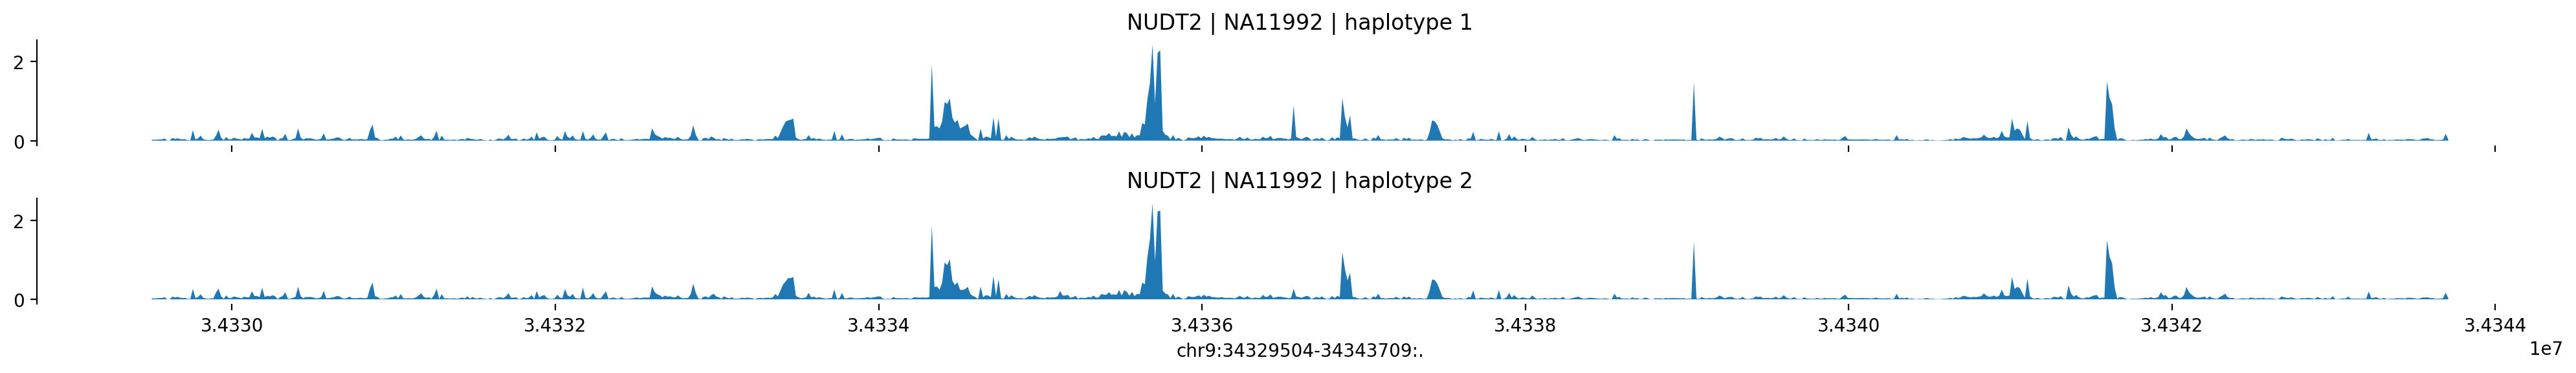

In [35]:
temp = prepare_for_plot_tracks(gene=exercise_1_genes[1], individual=exercise_1_individuals[0], all_predictions=exercise_1_predictions[1], chromosome=['9'])
plot_tracks(tracks=temp['gene_tracks'], interval=temp['gene_intervals'])

Looks nice!

Although it looks like there is no variation in the predictions for the haplotypes, we can take a look at the actual prediction values across the TSS.

The columns are the transcription start sites, and the rows are the haplotypes for the individual. The entries are the sum of the predictions at the *TSS*, at *TSS - 1*, and at the *TSS + 1*.

We will look at the first individual, **NA11992**, for **NUDT2**...

In [36]:
pd.DataFrame(exercise_1_predictions[0][exercise_1_genes[1]][exercise_1_individuals[0]], index=['haplotype_1', 'haplotype_2'])

,34329504
haplotype_1,360.296448
haplotype_2,349.091858


We will look at the first individual, **NA11992**, for **PEX6**...



In [37]:
pd.DataFrame(exercise_1_predictions[0][exercise_1_genes[3]][exercise_1_individuals[0]], index=['haplotype_1', 'haplotype_2'])

,42946888,42946958
haplotype_1,309.126953,309.126953
haplotype_2,309.773132,309.773132


Merely looking at the values, it looks like there are variations in the predictions across the haplotypes and the TSS. We expected some variations because we are predicting expression for each haplotype, which tend to have variations in them. Very nice!

## Comparing with true expression from GEUVADIS and with Predixcan

We should read in the GEUVADIS and Predixcan predictions.

In [38]:
geuvadis_gene_expression = pd.read_table('https://uchicago.box.com/shared/static/5vwc7pjw9qmtv7298c4rc7bcuicoyemt.gz', sep='\t',
                                         dtype={'gene_id': str, 'gene_name':str, 'TargetID':str, 'Chr':str})
geuvadis_gene_expression.head(5)

,gene_id,gene_name,TargetID,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,ENSG00000223972.4,DDX11L1,ENSG00000223972.4,1,11869,0.320818,0.344202,0.354225,0.478064,-0.102815,...,1.008605,0.384489,0.581284,0.513981,0.667449,0.350890,0.186103,-0.037976,0.405439,0.199143
1,ENSG00000227232.3,WASH7P,ENSG00000227232.3,1,29806,33.714457,20.185174,18.095407,24.100871,29.018719,...,30.980194,34.086207,39.678442,29.643513,27.120420,29.121624,31.117198,32.047074,22.798959,23.563874
2,ENSG00000243485.1,MIR1302-11,ENSG00000243485.1,1,29554,0.240408,0.157456,0.218806,0.320878,0.067833,...,0.065940,0.228784,0.140642,0.283905,0.273821,0.286311,0.324060,0.049574,0.255288,0.157440
3,ENSG00000238009.2,RP11-34P13.7,ENSG00000238009.2,1,133566,0.328272,0.327932,0.090064,0.420443,0.220269,...,0.274071,0.384179,0.533693,0.307221,0.307367,0.400278,0.612321,0.666633,0.281138,1.346129
4,ENSG00000239945.1,RP11-34P13.8,ENSG00000239945.1,1,91105,0.332171,-0.032164,0.017323,0.424677,0.214025,...,0.347323,0.346744,0.073580,0.400396,0.470517,0.069749,0.299353,0.090019,0.282554,-0.157170


In [39]:
predixcan_gene_expression = pd.read_table('https://uchicago.box.com/shared/static/4k68u7x7rxjpoljfdva6qipjxwzd3l0g.txt', sep=' ')
predixcan_gene_expression.head(5)

,gene_names_proper,gene_name,HG00315,HG00327,HG00334,HG00339,HG00341,HG00346,HG00353,HG00358,...,NA20760,NA20765,NA20772,NA20796,NA20804,NA20809,NA20811,NA20816,NA20828,NA20506
0,ENSG00000002016,RAD52,-0.250104,0.025857,-0.044889,-0.126075,-0.019377,-0.305435,-0.084487,-0.083447,...,0.067738,-0.032721,-0.044850,-0.136171,0.030402,-0.145576,0.000571,0.021220,0.006563,-0.012295
1,ENSG00000002549,LAP3,-0.139077,-0.324475,-0.314899,-0.316845,-0.279671,-0.142608,-0.318413,0.028499,...,-0.308563,-0.150983,0.017815,-0.333274,-0.130020,-0.312917,-0.289931,-0.148905,-0.324063,-0.151374
2,ENSG00000002726,AOC1,0.134822,0.004770,-0.182188,-0.238028,0.044468,-0.250673,-0.116671,-0.243399,...,0.018929,-0.021651,0.010531,0.364958,0.131044,-0.009168,-0.219884,-0.424765,-0.404101,0.006370
3,ENSG00000002822,MAD1L1,-0.130900,-0.138393,-0.113105,0.106536,-0.026348,-0.070047,-0.062220,-0.018478,...,-0.159111,-0.127137,-0.037308,-0.032433,-0.213594,-0.156237,-0.187337,-0.115429,-0.235621,-0.059553
4,ENSG00000003393,ALS2,0.250872,-0.202676,0.271500,0.282373,0.199417,-0.179208,-0.598147,-0.140201,...,0.238821,0.250585,0.185087,0.042159,0.244893,-0.185666,0.242587,0.234396,-0.294932,0.154260


#### ***QUESTION 3a***
What is the dimension/size/shape of the **geuvadis_gene_expression** dataframe? Hint: You can use the .shape method on a dataframe.

In [40]:
geuvadis_dimension = geuvadis_gene_expression.shape
print("The geuvadis_gene_expression dataframe has {} rows and {} columns".format(*geuvadis_dimension))

The geuvadis_gene_expression dataframe has 23722 rows and 467 columns


#### ***QUESTION 4b***
What is the dimension/size/shape of the **predixcan_gene_expression** dataframe? Hint: You can use the .shape method on a dataframe.

In [41]:
predixcan_dimension = predixcan_gene_expression.shape
print("The predixcan_gene_expression dataframe has {} rows and {} columns".format(*predixcan_dimension))

The predixcan_gene_expression dataframe has 4031 rows and 460 columns


We select the individuals and the gene from the geuvadis_gene_expression dataframe.

In [42]:
erap1_geuvadis_expression = geuvadis_gene_expression[geuvadis_gene_expression.gene_name == exercise_1_genes[0]].loc[:,exercise_1_individuals]
nudt2_geuvadis_expression = geuvadis_gene_expression[geuvadis_gene_expression.gene_name == exercise_1_genes[1]].loc[:,exercise_1_individuals]
erap2_geuvadis_expression = geuvadis_gene_expression[geuvadis_gene_expression.gene_name == exercise_1_genes[2]].loc[:,exercise_1_individuals]
pex6_geuvadis_expression = geuvadis_gene_expression[geuvadis_gene_expression.gene_name == exercise_1_genes[3]].loc[:,exercise_1_individuals]

In [43]:
nudt2_geuvadis_expression

,NA11992,NA19235,NA20770,HG00232,HG00342,NA20502,NA19189,HG00108,HG00380,NA12872
10804,23.713984,14.787901,16.181407,13.594301,20.765908,16.877474,12.753234,11.754371,10.113347,17.138522


We will sum the prediction for both haplotypes for each TSS, and take the sum of the resulting values. The function used here can also take the max instead of the sums.

We have 3 utility functions to help us
- plot_enformer_vs_guevadis
- plot_predixcan_vs_geuvadis
- plot_enformer_vs_predixcan (if you think this is necessary)

Correlation coefficient: 0.2248028760296875


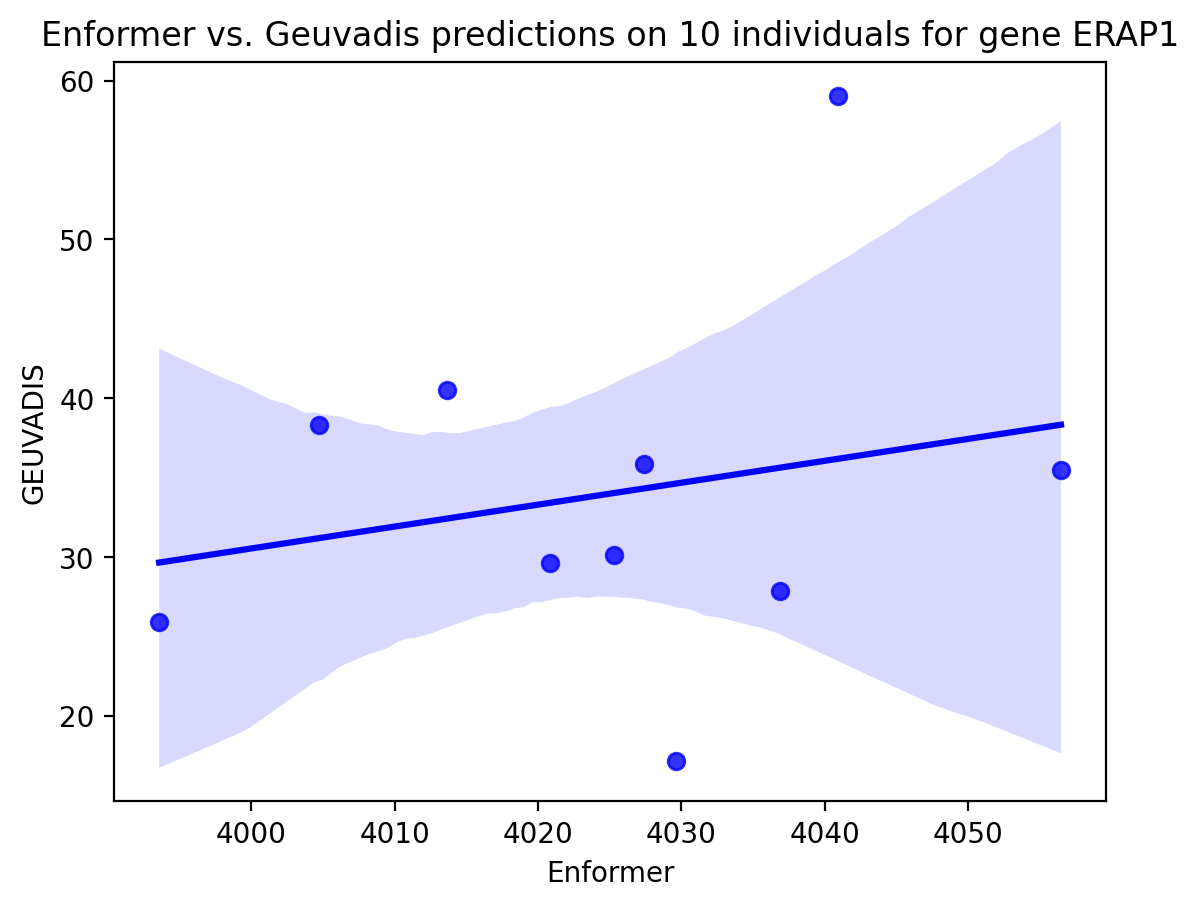

In [44]:
erap1_vs_geu = plot_enformer_vs_geuvadis(prediction_results=exercise_1_predictions, geuvadis_expression=geuvadis_gene_expression,
                            interested_gene=exercise_1_genes[0], interested_individuals=exercise_1_individuals, how='sum')
print('Correlation coefficient: {}'.format(erap1_vs_geu[1]))

Correlation coefficient: 0.8669689275345515


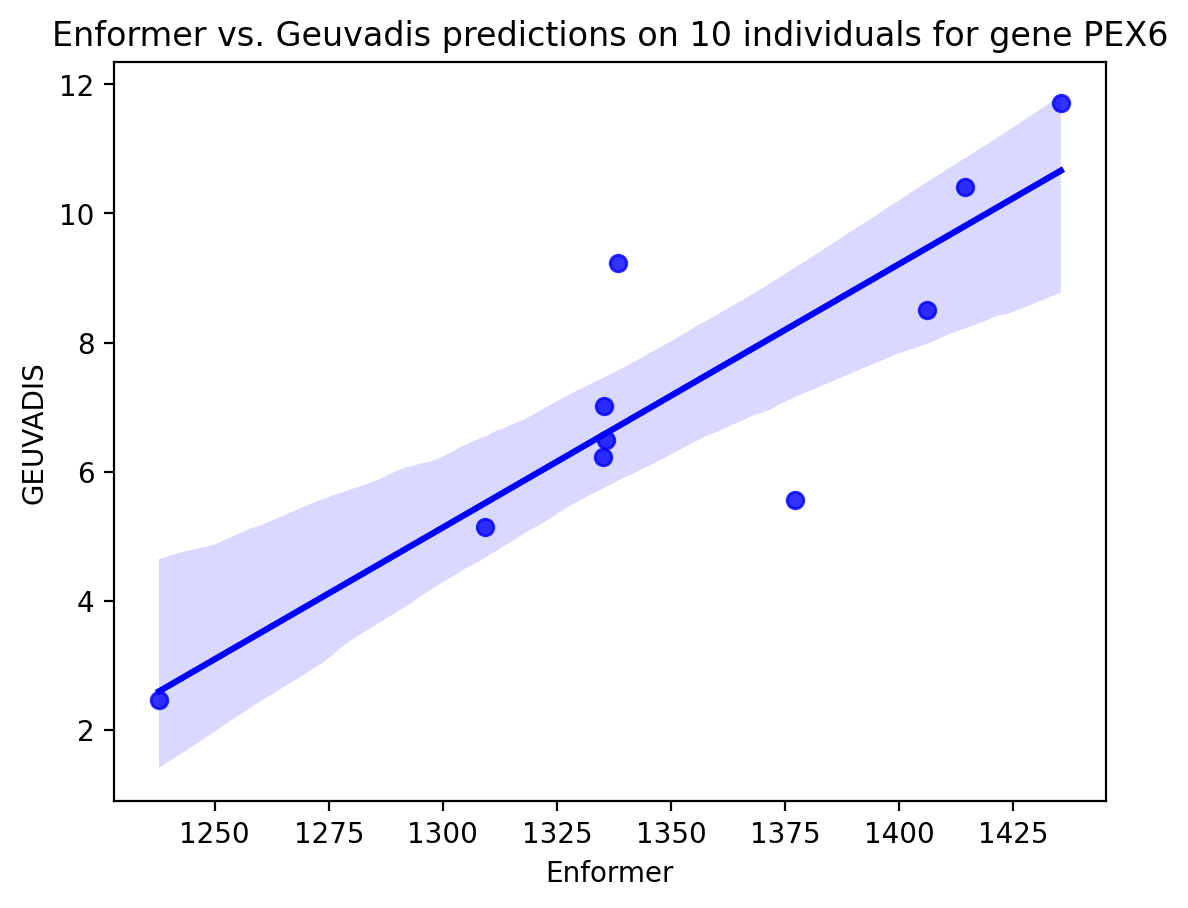

In [45]:
pex6_vs_geu = plot_enformer_vs_geuvadis(prediction_results=exercise_1_predictions, geuvadis_expression=geuvadis_gene_expression,
                            interested_gene=exercise_1_genes[3], interested_individuals=exercise_1_individuals, how='sum')

print('Correlation coefficient: {}'.format(pex6_vs_geu[1]))

Correlation coefficient: -0.7469431320173172


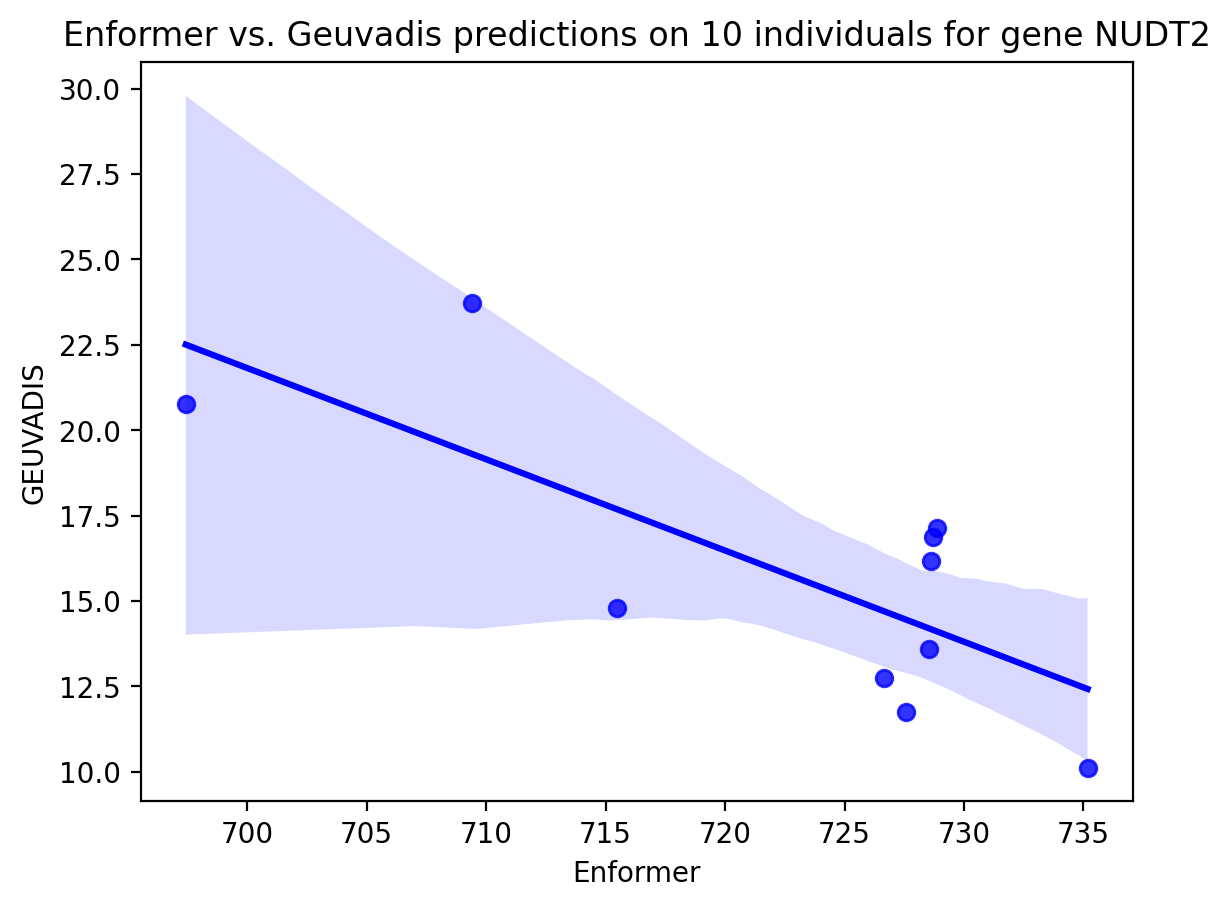

In [46]:
nudt_vs_geu = plot_enformer_vs_geuvadis(prediction_results=exercise_1_predictions, geuvadis_expression=geuvadis_gene_expression,
                            interested_gene=exercise_1_genes[1], interested_individuals=exercise_1_individuals, how='sum')

print('Correlation coefficient: {}'.format(nudt_vs_geu[1]))

Correlation coefficient: -0.46924360279488414


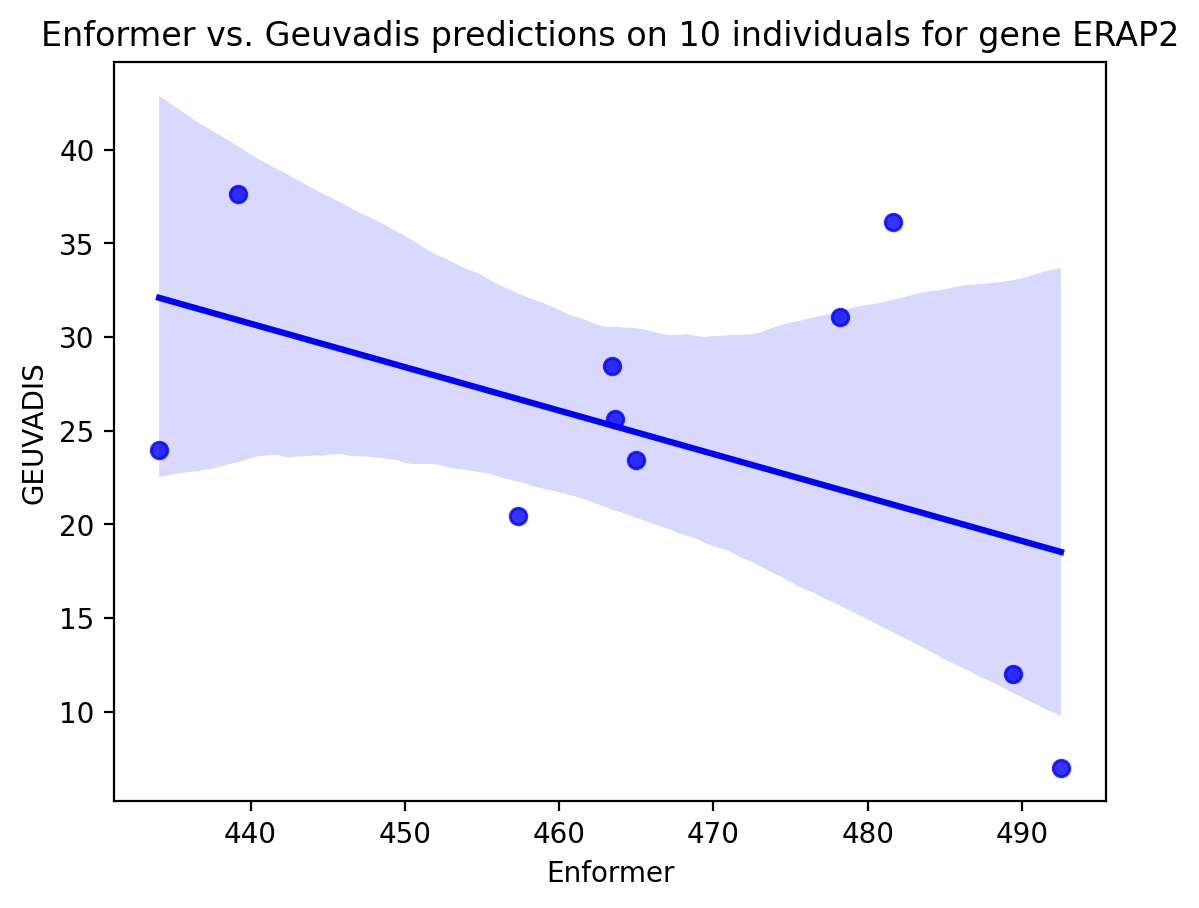

In [47]:
erap2_vs_geu = plot_enformer_vs_geuvadis(prediction_results=exercise_1_predictions, geuvadis_expression=geuvadis_gene_expression,
                            interested_gene=exercise_1_genes[2], interested_individuals=exercise_1_individuals, how='sum')

print('Correlation coefficient: {}'.format(erap2_vs_geu[1]))

Now, we can see how Predixcan performs on these individuals

The correlation coefficient: 0.8736403074571262


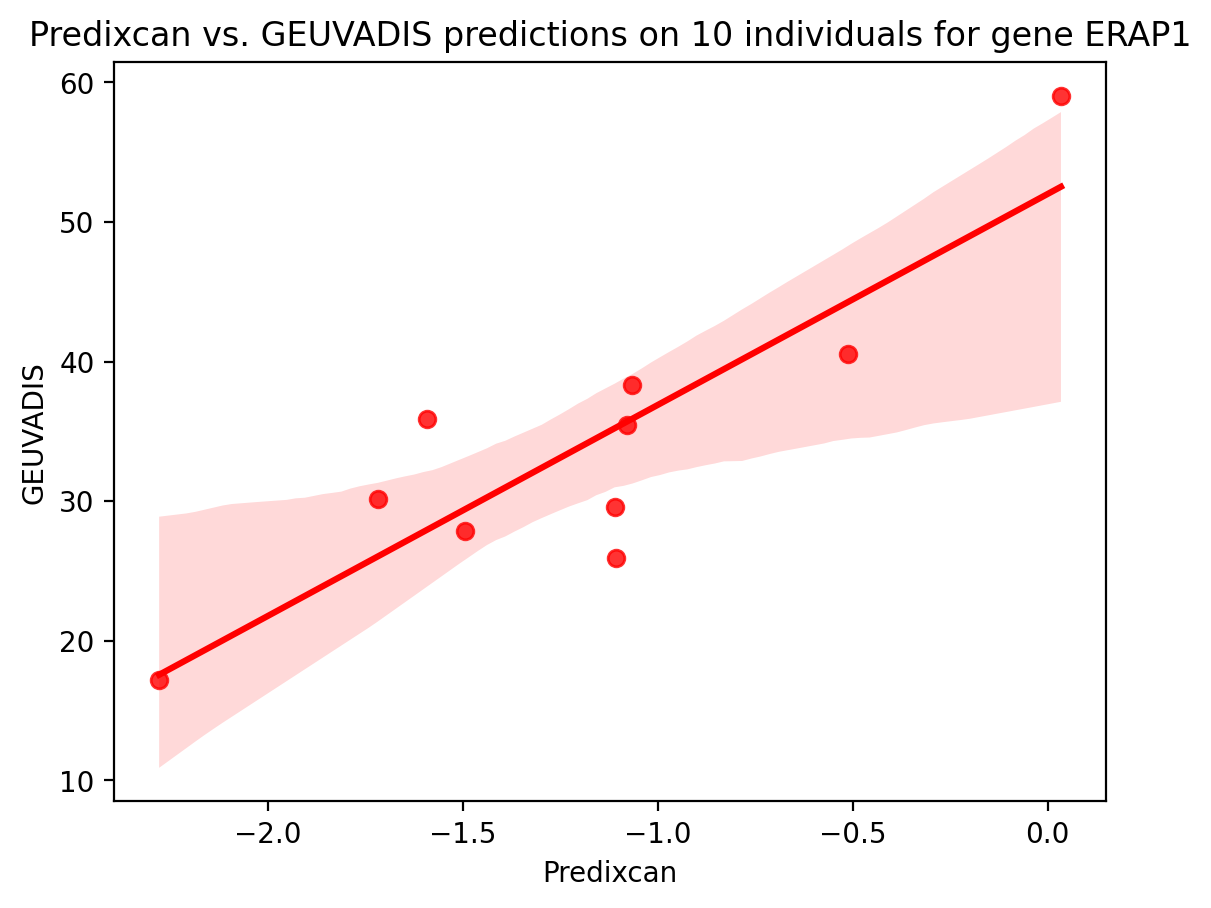

In [48]:
erap1_predix = plot_predixcan_vs_geuvadis(interested_gene=exercise_1_genes[0], interested_individuals=exercise_1_individuals, geuvadis_expression=geuvadis_gene_expression, predixcan_expression=predixcan_gene_expression)
print('The correlation coefficient: {}'.format(erap1_predix[1]))

The correlation coefficient: 0.9747939454280228


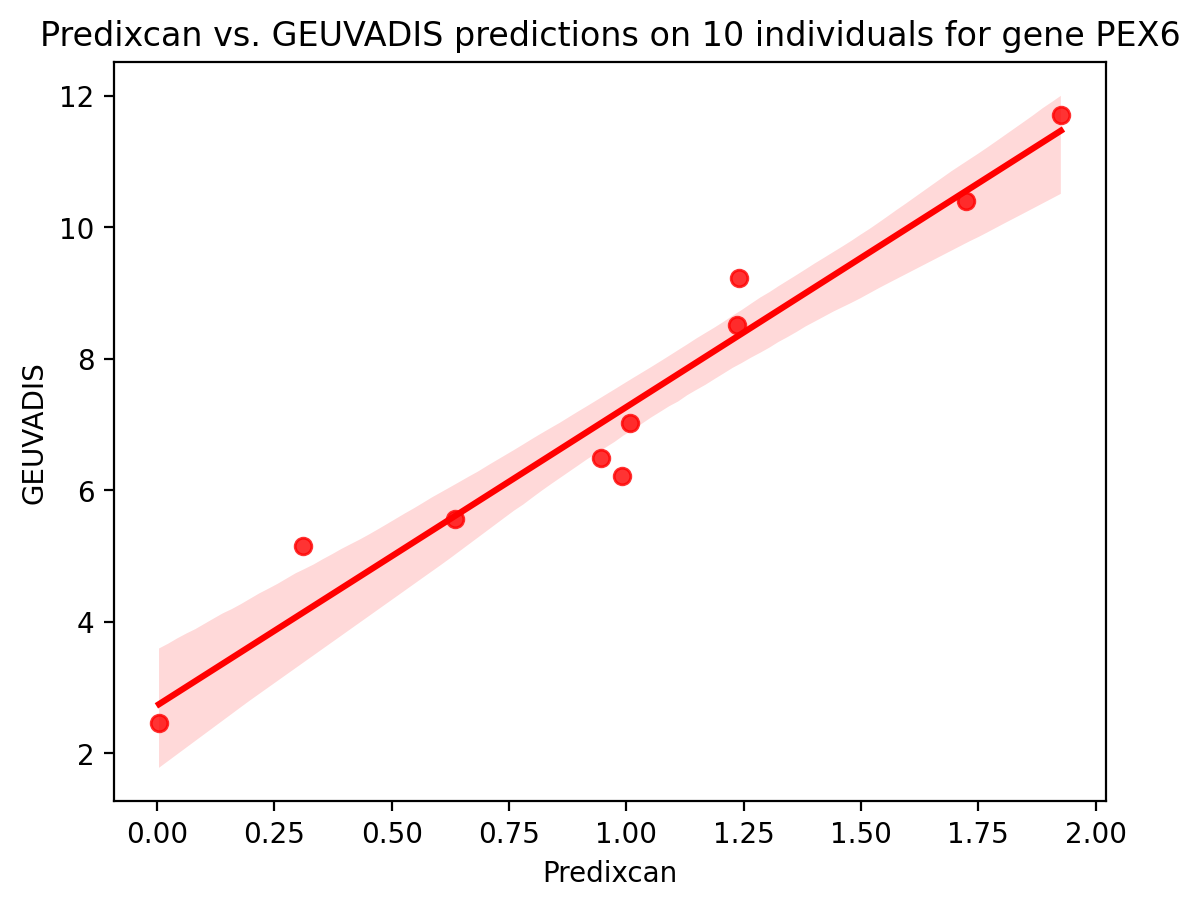

In [49]:
pex6_predix = plot_predixcan_vs_geuvadis(interested_gene=exercise_1_genes[3], interested_individuals=exercise_1_individuals, geuvadis_expression=geuvadis_gene_expression, predixcan_expression=predixcan_gene_expression)
print('The correlation coefficient: {}'.format(pex6_predix[1]))

The correlation coefficient: 0.7541638507596199


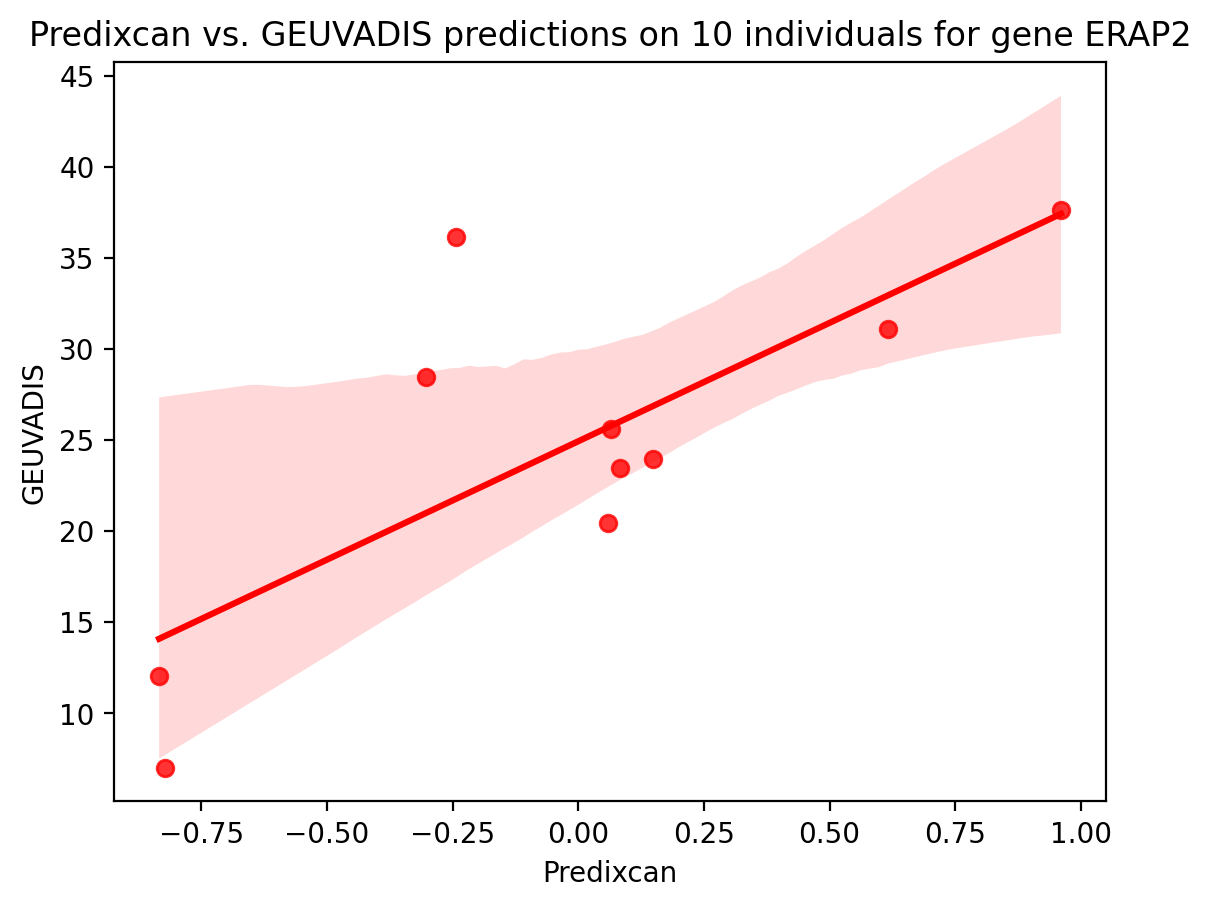

In [50]:
erap2_predix = plot_predixcan_vs_geuvadis(interested_gene=exercise_1_genes[2], interested_individuals=exercise_1_individuals, geuvadis_expression=geuvadis_gene_expression, predixcan_expression=predixcan_gene_expression)
print('The correlation coefficient: {}'.format(erap2_predix[1]))

The correlation coefficient: 0.7396287059598816


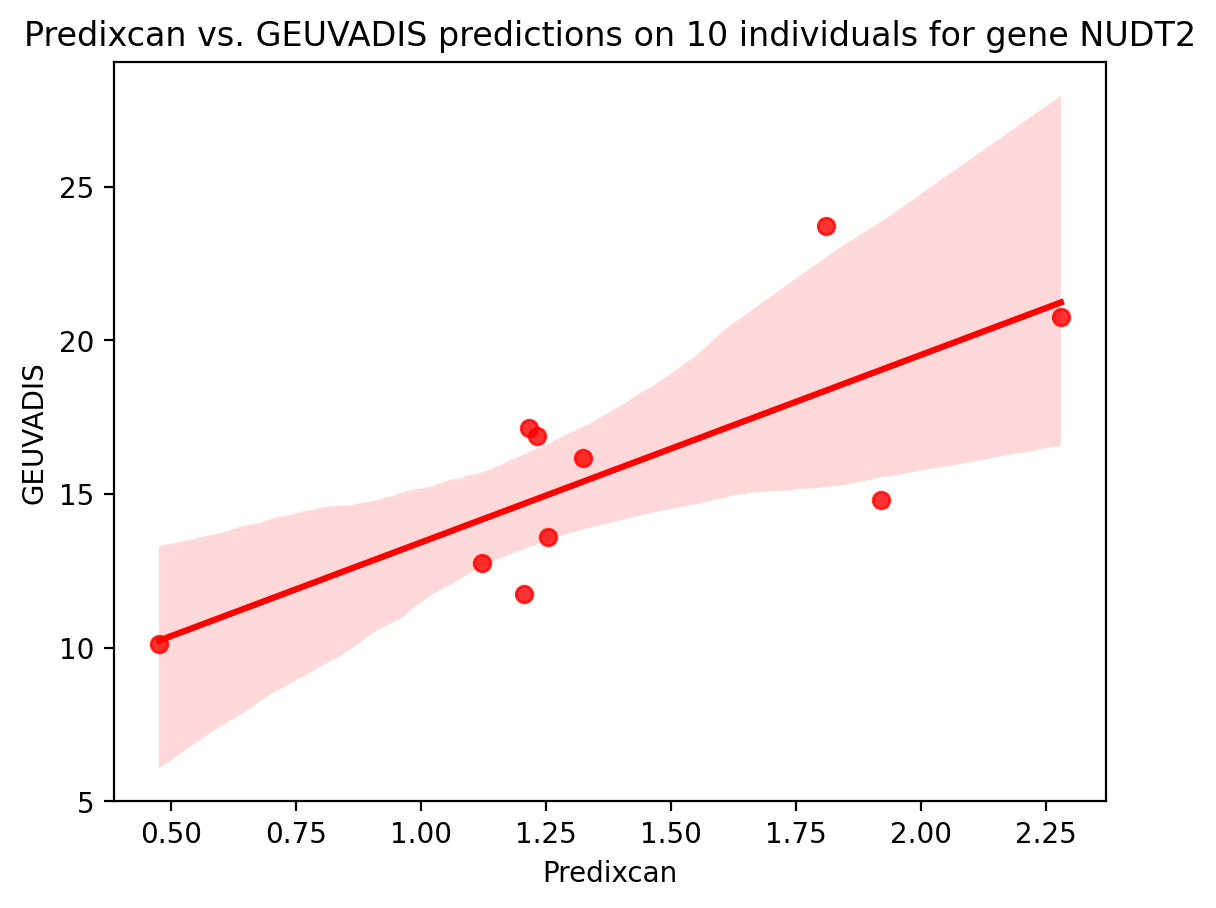

In [51]:
nudt2_predix = plot_predixcan_vs_geuvadis(interested_gene=exercise_1_genes[1], interested_individuals=exercise_1_individuals, geuvadis_expression=geuvadis_gene_expression, predixcan_expression=predixcan_gene_expression)
print('The correlation coefficient: {}'.format(nudt2_predix[1]))

Quite neat and impressive!

## **EXERCISE 2**

In this exercise, you will get your hands dirty, and run Enformer on your gene(s) of interest.

1. Select your favorite gene(s). **Note that the more genes you use, the longer it will take to run**.

2. Randomly select 10 individuals, just because we don't have all the computational power.

3. Run predictions


We only have data for a finite set of genes (sorry!). Here is a list of available genes you can use:

In [52]:
!curl -L https://uchicago.box.com/shared/static/x8d7dx1ykefz49ep6sxot42v44sfvcv5.tsv --output /grand/TFXcan/imlab/users/tiffanie/enformer/data/all_genes.tsv

with open("/grand/TFXcan/imlab/users/tiffanie/enformer/data/all_genes.tsv", "r") as ag:
  all_genes = [line.strip() for line in ag]
print(len(all_genes))
print("First 5 genes all_genes:", all_genes[0:5])


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     5    0     5    0     0      4      0 --:--:--  0:00:01 --:--:--  5000
100 20052  100 20052    0     0  15133      0  0:00:01  0:00:01 --:--:-- 15133
3114
First 5 genes all_genes: ['PEX10', 'TMEM69', 'ATAD3A', 'BPNT1', 'SNIP1']


1. Select your genes

In [53]:
my_genes = ['PEX10', 'TMEM69', 'ATAD3A', 'BPNT1', 'SNIP1']
print("My gene(s) is/are {}".format(', '.join(my_genes)))

My gene(s) is/are PEX10, TMEM69, ATAD3A, BPNT1, SNIP1


2. Read in the TSS txt files where those chromosome are located. If you have genes located on more than one chromosome, copy the **pd.read_table** line for each chromosome you have, and replace the chromosome number (ellipses) as appropriate.

In [55]:
my_chromosomes = [1] # put in the chromosomes where the genes are located. Just the numbers will do, or you can put them in as a string type

In [56]:
my_tss_list = []
for chr in my_chromosomes:
  chr = str(chr)
  bed_file = '/grand/TFXcan/imlab/users/tiffanie/enformer/data/tss_by_chr/chr{}_tss_by_gene.txt'.format(chr)
  my_tss_list.append(pd.read_table(bed_file, sep='\t')) # we read in the TSSs for each chromosome, and put them into a list

3. Randomly select 10 individuals

In [57]:
# let us set a seed to randomly select 10 individuals
np.random.seed(2023)  # replace ... with an integer you want

number_of_individuals = 10

my_individuals = np.random.choice(a=geuvadis_gene_expression.columns[6:-1], size=number_of_individuals, replace=False) # individuals we are interested in
my_individuals

array(['NA19144', 'NA18933', 'HG00327', 'NA19138', 'NA19096', 'HG00133',
       'NA20757', 'NA20803', 'NA18923', 'HG00355'], dtype=object)

4. We want to make sure that we have complete variation information for all 10 individuals.

First, we need to download the variation bed files for these individuals

In [58]:
download_chrom_beds(chromosome='1', genes=my_genes) # remember that the genes should be on that chromosome, and you can use this code for each chromosome you have.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--  8000
100 18.6M  100 18.6M    0     0  8183k      0  0:00:02  0:00:02 --:--:-- 21.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--  8000
100 18.6M  100 18.6M    0     0  7030k      0  0:00:02  0:00:02 --:--:-- 15.2M
  % Total    % Received % Xferd  Average Speed   Tim

Read in the variation bed files

In [59]:
import os

my_missing_list = list()
for chr in my_chromosomes:
  for gene in my_genes:
    chr = str(chr)
    file_path = '/grand/TFXcan/imlab/users/tiffanie/enformer/data/individual_beds/chr' + chr + '/chr' + chr + '_' + gene + '.bed'
    if not os.path.exists(file_path):
      continue
    my_missing_list.append(check_individuals(file_path, my_individuals))

All individuals are present in the bed file.
All individuals are present in the bed file.
All individuals are present in the bed file.
All individuals are present in the bed file.
All individuals are present in the bed file.


#### ***QUESTION 4***
Are there missing individuals? All answers, based on your results are correct. If there are missing individuals, can you remove them? You can add new code blocks as you like.

In [60]:
my_missing_list #no missing individuals

[[], [], [], [], []]

It looks like we are almost set to make predictions.

5. Make predictions. First, we will collect the intervals for the genes we want, check the object and make sure we are on the right track. Next, we will call our **run_predictions** function.

In [ ]:
chr5_tss = pd.read_table('/grand/TFXcan/imlab/users/tiffanie/enformer/data/tss_by_chr/chr5_tss_by_gene.txt', sep='\t')

In [62]:
my_intervals = collect_intervals(chromosomes= ["1"], gene_list= my_genes) # here, we collect the intervals for that gene; replace ... with the right objects
my_intervals

{'PEX10': ['1', 2336236, 2345236],
 'TMEM69': ['1', 46152886, 46160115],
 'ATAD3A': ['1', 1447531, 1470067],
 'BPNT1': ['1', 220230824, 220263804],
 'SNIP1': ['1', 38002142, 38019905]}

In [64]:
my_predictions = run_predictions(gene_intervals= my_intervals, tss_dataframe= my_tss_list, individuals_list=my_individuals)

Currently on gene PEX10, and predicting on individual NA19144...
Currently on gene PEX10, and predicting on individual NA18933...
Currently on gene PEX10, and predicting on individual HG00327...
Currently on gene PEX10, and predicting on individual NA19138...
Currently on gene PEX10, and predicting on individual NA19096...
Currently on gene PEX10, and predicting on individual HG00133...
Currently on gene PEX10, and predicting on individual NA20757...
Currently on gene PEX10, and predicting on individual NA20803...
Currently on gene PEX10, and predicting on individual NA18923...
Currently on gene PEX10, and predicting on individual HG00355...
Currently on gene TMEM69, and predicting on individual NA19144...
Currently on gene TMEM69, and predicting on individual NA18933...
Currently on gene TMEM69, and predicting on individual HG00327...
Currently on gene TMEM69, and predicting on individual NA19138...
Currently on gene TMEM69, and predicting on individual NA19096...
Currently on gene TM

At this point, we will leave you to make your own plots...

In [66]:
len(my_predictions)

2

In [67]:
my_genes

['PEX10', 'TMEM69', 'ATAD3A', 'BPNT1', 'SNIP1']

ex. plotting PEX10 (located on chr1) expression levels in the first individual (NA19144)

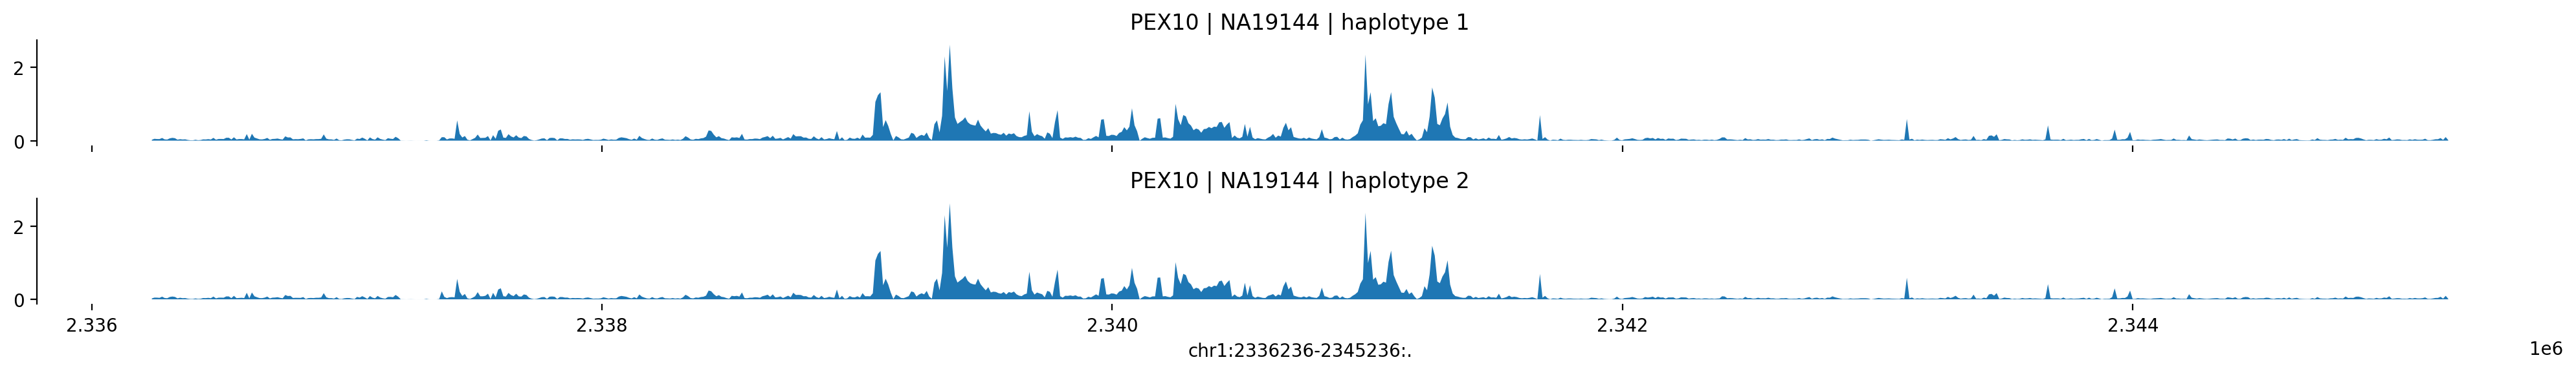

In [68]:
prep_pex10_plt = prepare_for_plot_tracks(gene=my_genes[0], individual=my_individuals[0], all_predictions=my_predictions[1], chromosome=['1'])
plot_tracks(tracks=prep_pex10_plt['gene_tracks'], interval=prep_pex10_plt['gene_intervals'])